In [1]:
import pandas as pd
import numpy
import numpy as np

# For modeling the stocks
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, t
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime, timedelta

In [2]:
# Import dart APIs
from darts import TimeSeries
from darts.models import RNNModel, TFTModel
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.losses import MAELoss

### Predicting the closing price stock price of APPLE inc:

### Checking Data

In [3]:
# Get the stock quote
#df = DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.now())
df = yf.download('BTC-USD', start=datetime.now() - timedelta(days=14000), end=datetime.now(), interval='1d')
# Show teh data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-08-19,23213.312500,23213.312500,20868.847656,20877.552734,20877.552734,40509610260
2022-08-20,20872.841797,21350.806641,20856.730469,21166.060547,21166.060547,27595671000
2022-08-21,21160.392578,21668.845703,21103.197266,21534.121094,21534.121094,23102307723


In [4]:
df['Return'] = df['Close'].pct_change()
df = df.fillna(0)
df

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.000000
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659
...,...,...,...,...,...,...,...
2022-08-19,23213.312500,23213.312500,20868.847656,20877.552734,20877.552734,40509610260,-0.100599
2022-08-20,20872.841797,21350.806641,20856.730469,21166.060547,21166.060547,27595671000,0.013819
2022-08-21,21160.392578,21668.845703,21103.197266,21534.121094,21534.121094,23102307723,0.017389


In [5]:
low_low=[]

for row in range(len(df)):
    if df.iloc[row-1, 2] > df.iloc[row, 2]:
        low_low.append(0)
        
    elif (df.iloc[row-1, 2] < df.iloc[row, 2]):
        low_low.append(1)
        
    elif (df.iloc[row-1, 2] == df.iloc[row, 2]):
        low_low.append(-1)
        
low_low = np.array(low_low)        
low_low = np.transpose(low_low).reshape(-1,1)
df['Custom lows'] = low_low
df

,Open,High,Low,Close,Adj Close,Volume,Return,Custom lows
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.000000,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735,1
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659,1
...,...,...,...,...,...,...,...,...
2022-08-19,23213.312500,23213.312500,20868.847656,20877.552734,20877.552734,40509610260,-0.100599,0
2022-08-20,20872.841797,21350.806641,20856.730469,21166.060547,21166.060547,27595671000,0.013819,0
2022-08-21,21160.392578,21668.845703,21103.197266,21534.121094,21534.121094,23102307723,0.017389,1


In [6]:
high_high=[]

for row in range(len(df)):
    if df.iloc[row-1, 1] > df.iloc[row, 1]:
        high_high.append(0)
        
    elif (df.iloc[row-1, 1] < df.iloc[row, 1]):
        high_high.append(1)
        
    elif (df.iloc[row-1, 1] == df.iloc[row, 1]):
        high_high.append(-1)
        
high_high = np.array(high_high)        
high_high = np.transpose(high_high).reshape(-1,1)
df['Custom highs'] = high_high
df

,Open,High,Low,Close,Adj Close,Volume,Return,Custom lows,Custom highs
Date,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.000000,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735,1,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659,1,0
...,...,...,...,...,...,...,...,...,...
2022-08-19,23213.312500,23213.312500,20868.847656,20877.552734,20877.552734,40509610260,-0.100599,0,0
2022-08-20,20872.841797,21350.806641,20856.730469,21166.060547,21166.060547,27595671000,0.013819,0,0
2022-08-21,21160.392578,21668.845703,21103.197266,21534.121094,21534.121094,23102307723,0.017389,1,1


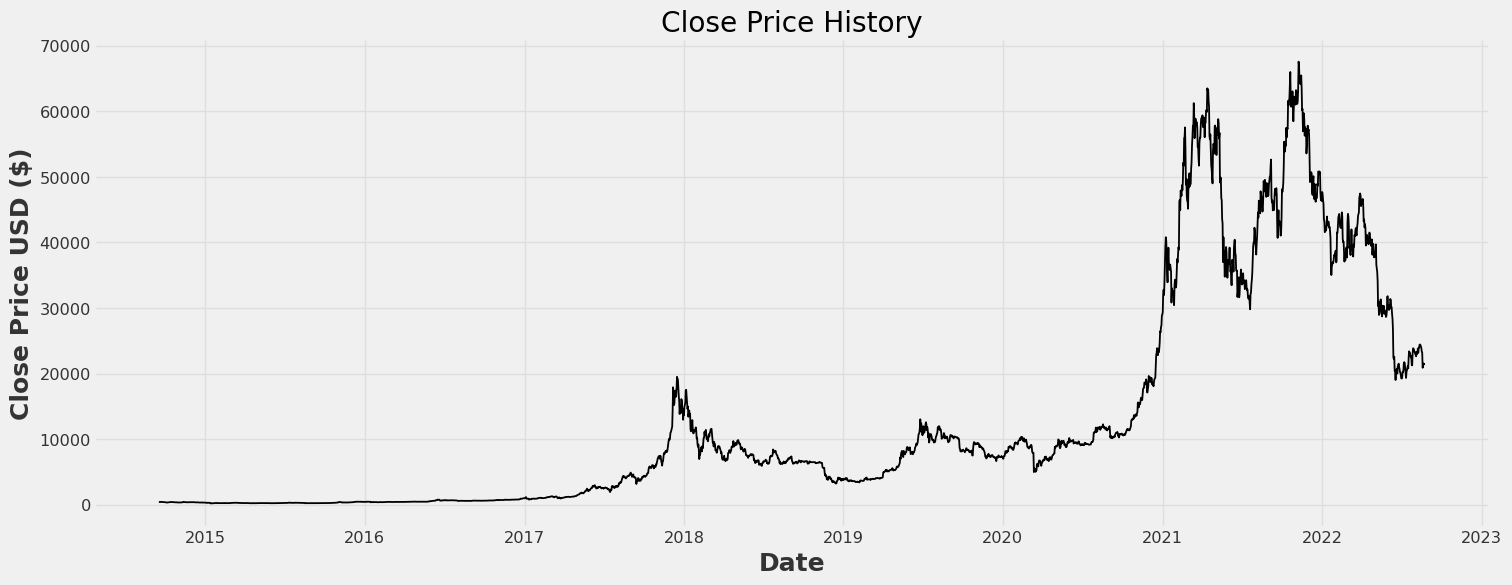

In [7]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
#plt.hist(df['Volume']);
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

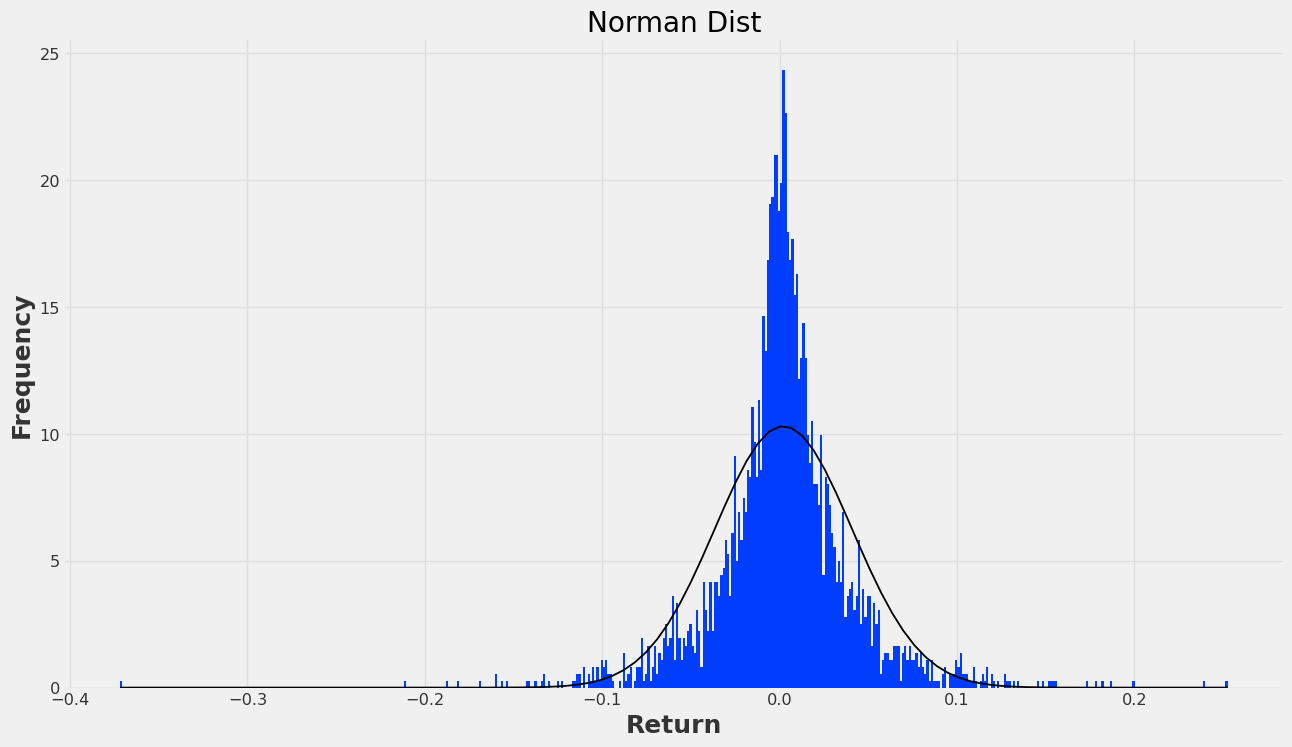

In [8]:
x_list = np.linspace(
                    df['Return'].min(),
                    df['Return'].max(),
                    100
                    )

y_list = norm.pdf(x_list, loc=df['Return'].mean(), scale=df['Return'].std())

plt.figure(figsize=(14,8))
plt.title('Norman Dist')
plt.xlabel('Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['Return'], bins=500,density=True);

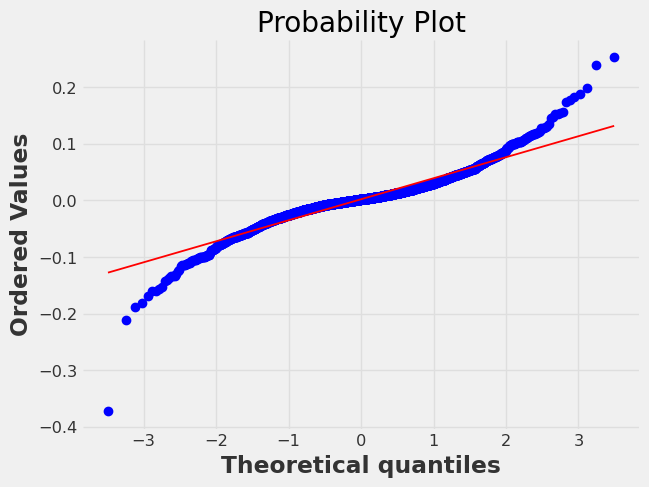

In [9]:
probplot(df['Return'],dist='norm',fit= True,plot=plt);

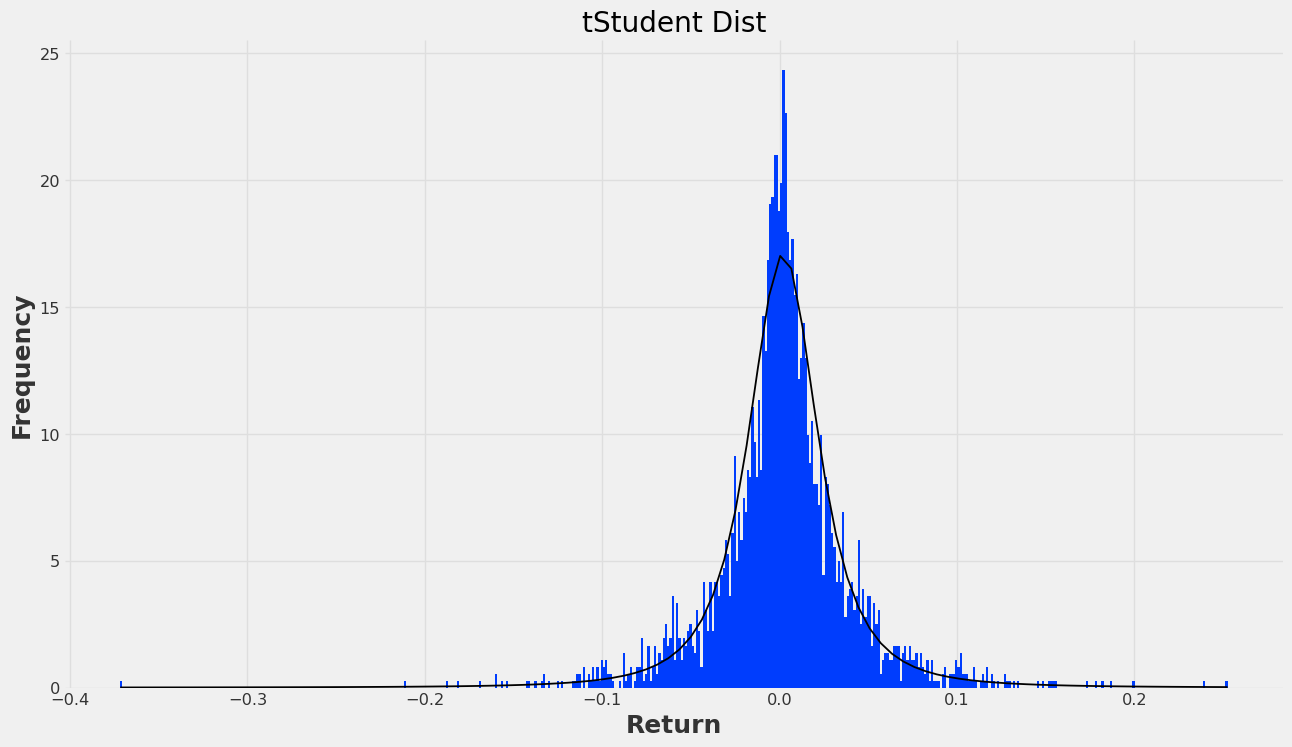

In [10]:
x_list = np.linspace(
                    df['Return'].min(),
                    df['Return'].max(),
                    100
                    )

params = t.fit(df['Return'].dropna())
degree_of_freedom, loc, scale = params

y_list = t.pdf(x_list, degree_of_freedom, loc, scale)

plt.figure(figsize=(14,8))
plt.title('tStudent Dist')
plt.xlabel('Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['Return'], bins=500,density=True);

### Proccessing data

In [11]:
# featurs list
features = ['Return']
feature_size = len(features)
feature_size

1

In [12]:
# Create a new dataframe with only the 'Close' and 'volume' column 
df = df.filter(features)
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,Return
Date,
2014-09-17,0.000000
2014-09-18,-0.071926
2014-09-19,-0.069843
2014-09-20,0.035735
2014-09-21,-0.024659
...,...
2022-08-19,-0.100599
2022-08-20,0.013819
2022-08-21,0.017389


In [13]:
data = TimeSeries.from_dataframe(df, fill_missing_dates=False, freq='D')
print(data)

<TimeSeries (DataArray) (Date: 2898, component: 1, sample: 1)>
array([[[ 0.        ]],

       [[-0.07192558]],

       [[-0.06984265]],

       ...,

       [[ 0.01738919]],

       [[-0.00627901]],

       [[ 0.00665475]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2014-09-17 2014-09-18 ... 2022-08-23
  * component  (component) object 'Return'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [14]:
# Get the number of rows to train the model on (9% of total data)
x_train, x_test = data.split_after(0.9)

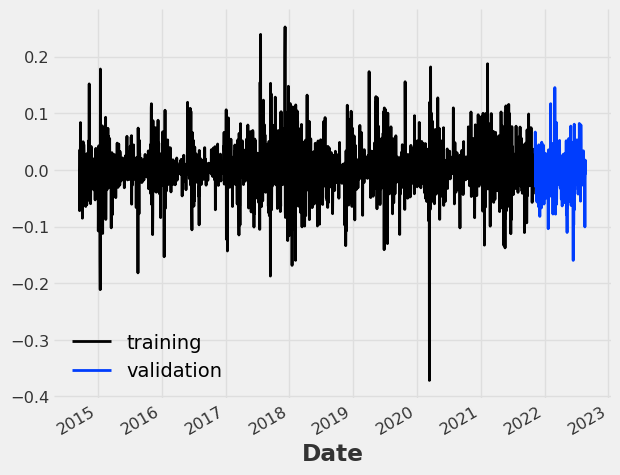

In [15]:
x_train.plot(label="training")
x_test.plot(label="validation")

In [16]:
x_train.plot(label="training")
x_test.plot(label="validation")

<TimeSeries (DataArray) (Date: 2608, component: 1, sample: 1)>
array([[[0.59550623]],

       [[0.48027174]],

       [[0.48360888]],

       ...,

       [[0.55688871]],

       [[0.58699255]],

       [[0.60603774]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2014-09-17 2014-09-18 ... 2021-11-06
  * component  (component) object 'Return'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [26]:
encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['absolute'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'transformer': Scaler()
}

# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=2,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=10,
    add_relative_index=False,
    add_encoders=encoders,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    #loss_fn=MAELoss(),
    random_state=42,
)

In [27]:
model = my_model.fit(rescaled_train, verbose=True)

C:\Users\HKamkar\.conda\envs\darts\lib\site-packages\darts\timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-08-23 19:22:44 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-08-23 19:22:44 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-08-23 19:22:44 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-08-23 19:22:44 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 

Training: 0it [00:00, ?it/s]

In [28]:
my_model.fit(rescaled_train, verbose=True)

Predicting: 161it [00:00, ?it/s]

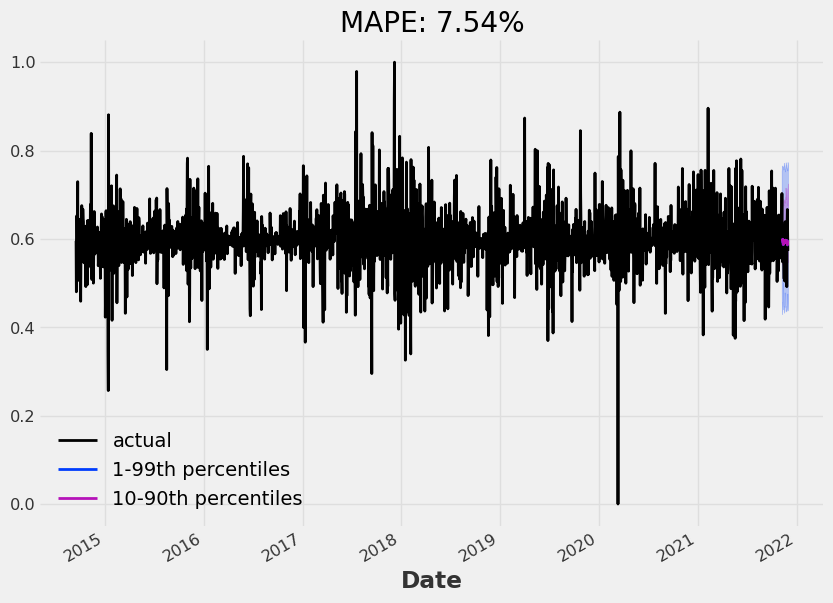

In [29]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

Predicting: 161it [00:00, ?it/s]

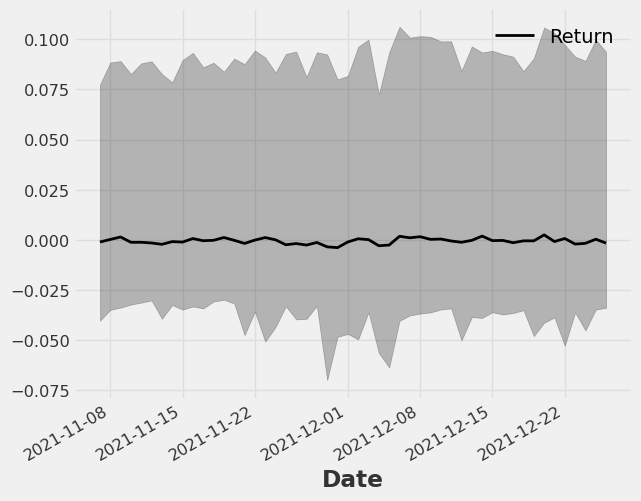

In [30]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)
    #pred_series = scaler.inverse_transform(pred_series)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


prediction = eval_model(my_model, 24, rescaled_data, rescaled_test)